# Naive RAG

**절차**

1. Naive RAG 수행

![langgraph-naive-rag](assets/langgraph-naive-rag.png)

## 환경 설정

In [ ]:
# !pip install -U langchain-teddynote

In [7]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

## 기본 PDF 기반 Retrieval Chain 생성

여기서는 PDF 문서를 기반으로 Retrieval Chain 을 생성합니다. 가장 단순한 구조의 Retrieval Chain 입니다.

단, LangGraph 에서는 Retirever 와 Chain 을 따로 생성합니다. 그래야 각 노드별로 세부 처리를 할 수 있습니다.

In [8]:
from rag.pdf import PDFRetrievalChain

# PDF 문서를 로드합니다.
pdf = PDFRetrievalChain(["data/2024_프로야구_리그규정_요약.pdf"]).create_chain()

# retriever와 chain을 생성합니다.
pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

먼저, pdf_retriever 를 사용하여 검색 결과를 가져옵니다.

In [9]:
search_result = pdf_retriever.invoke("각 구단은 몇 경기씩 해?")
search_result

[Document(id='deb46e5b-9121-4b40-84b1-18855f58db3e', metadata={'source': 'data/2024_프로야구_리그규정_요약.pdf', 'file_path': 'data/2024_프로야구_리그규정_요약.pdf', 'page': 14, 'total_pages': 18, 'CreationDate': "D:20240403201030-09'00'", 'Creator': 'nPDF (pdftk 1.41)', 'ModDate': 'D:20241228092714Z', 'Producer': '3-Heightsâ—¢ PDF Optimization Shell 6.3.1.5 (http://www.pdf-tools.com)'}, page_content='양 구단의 선수를 심판위원으로 충당하여 경기를 개시한다. 이\n경우 심판위원이 경기 도중에 도착하면 즉시 심판위원으로 교\n체하여 경기를 속행하여야 한다.\n(주)양 구단의 선수를 심판위원으로 충당할 경우 양 구단의 감독들은 상호 상\n대편 선수 중에서 경기에 참가하지 않은 선수를 동수로 선정한다. 그리고 루심\n의 배정은 홈구단에서 주심과 2루심, 원정구단에서 1,3루심을 담당케 하며, 제\n복은 선수와 구별하기 위하여 상의는 점퍼를 착용하여야 한다.\n5. 기록위원이 사고로 부재인 경우에는 경기관리인이 구단 기록'),
 Document(id='4e36da84-e28f-43ea-b91d-76cb2d0118e7', metadata={'source': 'data/2024_프로야구_리그규정_요약.pdf', 'file_path': 'data/2024_프로야구_리그규정_요약.pdf', 'page': 12, 'total_pages': 18, 'CreationDate': "D:20240403201030-09'00'", 'Creator': 'nPDF (pdftk 1.41)', 'ModDate': 'D:20241228092714Z', 'Producer': '3-Heightsâ—¢ PDF Optimi

이전에 검색한 결과를 chain 의 context 로 전달합니다.

In [10]:
# 검색 결과를 기반으로 답변을 생성합니다.
answer = pdf_chain.invoke(
    {
        "question": "각 구단은 몇 경기씩 해?",
        "context": search_result,
        "chat_history": [],
    }
)
print(answer)

각 구단은 144경기씩 진행합니다. 총 720경기가 거행됩니다.

**Source**
- data/2024_프로야구_리그규정_요약.pdf (page 2)


## State 정의

`State`: Graph 의 노드와 노드 간 공유하는 상태를 정의합니다.

일반적으로 `TypedDict` 형식을 사용합니다.

In [11]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages


# GraphState 상태 정의
class GraphState(TypedDict):
    question: Annotated[str, "Question"]  # 질문
    context: Annotated[str, "Context"]  # 문서의 검색 결과
    answer: Annotated[str, "Answer"]  # 답변
    messages: Annotated[list, add_messages]  # 메시지(누적되는 list)

## 노드(Node) 정의

- `Nodes`: 각 단계를 처리하는 노드입니다. 보통은 Python 함수로 구현합니다. 입력과 출력이 상태(State) 값입니다.
  
**참고**  

- `State`를 입력으로 받아 정의된 로직을 수행한 후 업데이트된 `State`를 반환합니다.

In [14]:
from share.messages import messages_to_history
from rag.utils import format_docs


# 문서 검색 노드
def retrieve_document(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    retrieved_docs = pdf_retriever.invoke(latest_question)

    # 검색된 문서를 형식화합니다.(프롬프트 입력으로 넣어주기 위함)
    retrieved_docs = format_docs(retrieved_docs)

    # 검색된 문서를 context 키에 저장합니다.
    return {"context": retrieved_docs}
    # return GraphState(context=retrieved_docs)


# 답변 생성 노드
def llm_answer(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 검색된 문서를 상태에서 가져옵니다.
    context = state["context"]

    # 체인을 호출하여 답변을 생성합니다.
    response = pdf_chain.invoke(
        {
            "question": latest_question,
            "context": context,
            "chat_history": messages_to_history(state["messages"]),
        }
    )
    # 생성된 답변, (유저의 질문, 답변) 메시지를 상태에 저장합니다.
    return {
        "answer": response,
        "messages": [("user", latest_question), ("assistant", response)],
    }

## 그래프 생성

- `Edges`: 현재 `State`를 기반으로 다음에 실행할 `Node`를 결정하는 Python 함수.

일반 엣지, 조건부 엣지 등이 있습니다.

In [15]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# 그래프 생성
workflow = StateGraph(GraphState)

# 노드 정의
workflow.add_node("retrieve", retrieve_document)
workflow.add_node("llm_answer", llm_answer)

# 엣지 정의
workflow.add_edge("retrieve", "llm_answer")  # 검색 -> 답변
workflow.add_edge("llm_answer", END)  # 답변 -> 종료

# 그래프 진입점 설정
workflow.set_entry_point("retrieve")

# 체크포인터 설정
memory = MemorySaver()

# 컴파일
app = workflow.compile(checkpointer=memory)

컴파일한 그래프를 시각화 합니다.

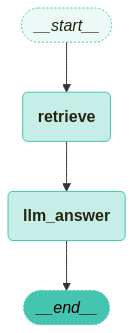

In [16]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

## 그래프 실행

- `config` 파라미터는 그래프 실행 시 필요한 설정 정보를 전달합니다.
- `recursion_limit`: 그래프 실행 시 재귀 최대 횟수를 설정합니다.
- `inputs`: 그래프 실행 시 필요한 입력 정보를 전달합니다.

**참고**

- 메시지 출력 스트리밍은 [LangGraph 스트리밍 모드의 모든 것](https://wikidocs.net/265770) 을 참고해주세요.

아래의 `stream_graph` 함수는 특정 노드만 스트리밍 출력하는 함수입니다.

손쉽게 특정 노드의 스트리밍 출력을 확인할 수 있습니다.

In [17]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import invoke_graph, stream_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = GraphState(question="각 구단은 몇 경기씩 해?")

# 그래프 실행
invoke_graph(app, inputs, config)


🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
context:
<document><content>양 구단의 선수를 심판위원으로 충당하여 경기를 개시한다. 이
경우 심판위원이 경기 도중에 도착하면 즉시 심판위원으로 교
체하여 경기를 속행하여야 한다.
(주)양 구단의 선수를 심판위원으로 충당할 경우 양 구단의 감독들은 상호 상
대편 선수 중에서 경기에 참가하지 않은 선수를 동수로 선정한다. 그리고 루심
의 배정은 홈구단에서 주심과 2루심, 원정구단에서 1,3루심을 담당케 하며, 제
복은 선수와 구별하기 위하여 상의는 점퍼를 착용하여야 한다.
5. 기록위원이 사고로 부재인 경우에는 경기관리인이 구단 기록</content><source>data/2024_프로야구_리그규정_요약.pdf</source><page>15</page></document>
<document><content>3. 봉인해제 후 경기 중 사용하지 않은 경기사용구는 경기종료 후
심판위원이 별도로 봉인하여 다음 경기에 사용할 수 있도록 한다.
제17조 구단기 게양
홈구단은 전 구단기를 상비하여 경기가 행하여지는 당일 양 구단
기를 게양하여야 한다.
전년도 우승구단은 구단기와 소정의 우승기를 함께 게양하여야
한다.
제18조 입장요금
입장요금은 각 구단이 자율적으로 결정하여 시행한다.
제19조 응원시 금지사항
구장 내의 관객석에서 앰프(AMP)를 사용하는 등 과도한 응원 행
위로 관객에게 불쾌감을 주거나 경기에 지장을 줄 경우 주심은 경</content><source>data/2024_프로야구_리그규정_요약.pdf</source><page>13</page></document>
<document><content>제1장 KBO 정규시즌
제1조 경기방식
1. 단일 리그제로 각 구단은 144경기(구단간 16차전)씩
총 720경기를 거행한다.
2. 연장전은 12회(KBO 포스트시즌 15회)까지로 하고 승패를
가리지 못할 경우에는 무승부로

In [18]:
# 그래프를 스트리밍 출력
stream_graph(app, inputs, config)


🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
각 구단은 144경기를 치릅니다. 총 720경기가 진행됩니다.

**Source**
- data/2024_프로야구_리그규정_요약.pdf (page 3)

In [19]:
outputs = app.get_state(config).values

print(f'Question: {outputs["question"]}')
print("===" * 20)
print(f'Answer:\n{outputs["answer"]}')

Question: 각 구단은 몇 경기씩 해?
Answer:
각 구단은 144경기를 치릅니다. 총 720경기가 진행됩니다.

**Source**
- data/2024_프로야구_리그규정_요약.pdf (page 3)
